Epoch 1/128


D:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0571
Epoch 2/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0055
Epoch 3/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0055
Epoch 4/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0050
Epoch 5/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042
Epoch 6/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0039
Epoch 7/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0037
Epoch 8/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0045
Epoch 9/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039
Epoch 10/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0029
Epoch 11/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0036
Epoch 12/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0034
Epoch 13/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0031
Epoch 14/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0035
Epoch 15/128
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0027
E

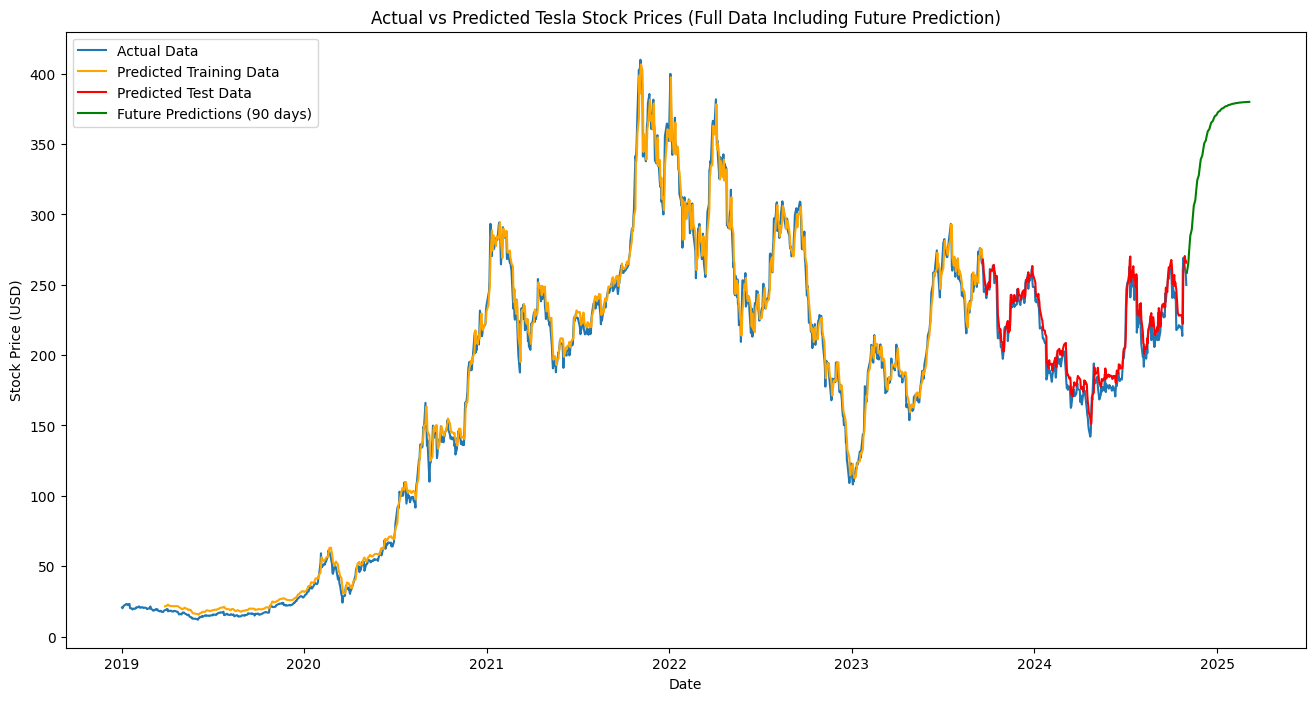

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Step 1: Load the data
tesla_data = pd.read_csv('Get_data/Tesla_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')
sp500_data = pd.read_csv('Get_data/S&P500_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')
ixic_data = pd.read_csv('Get_data/IXIC_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')

# Merge datasets on 'Date'
merged_data = tesla_data.merge(sp500_data, left_index=True, right_index=True, suffixes=('', '_sp500'))
merged_data = merged_data.merge(ixic_data, left_index=True, right_index=True, suffixes=('', '_ixic'))

# Step 2: Preprocess the data
data = merged_data[['Close', 'Close_sp500', 'Close_ixic']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Prepare the dataset for LSTM
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i - time_step:i])
        y.append(dataset[i, 0])  # Predict the 'Close' price of Tesla
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 3: Build and train the LSTM model
model = Sequential([
    LSTM(57, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2714727016483041),
    LSTM(57),
    Dropout(0.2714727016483041),
    Dense(1)
])
optimizer = Adam(learning_rate=0.0010820784404161896)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train, y_train, epochs=128, batch_size=16, verbose=1)

# Step 4: Make predictions on the test set
test_predictions = model.predict(X_test)

# Rescale predictions and true values to original scale
test_predictions_rescaled = scaler.inverse_transform(
    np.hstack([test_predictions, X_test[:, -1, 1:]])
)[:, 0]
y_test_rescaled = scaler.inverse_transform(
    np.hstack([y_test.reshape(-1, 1), X_test[:, -1, 1:]])
)[:, 0]

# Step 5: Calculate performance metrics
test_rmse = np.sqrt(mean_squared_error(y_test_rescaled, test_predictions_rescaled))
test_mape = mean_absolute_percentage_error(y_test_rescaled, test_predictions_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, test_predictions_rescaled)

print(f'Test RMSE: {test_rmse:.2f}')
print(f'Test MAPE: {test_mape:.2%}')
print(f'Test MAE: {test_mae:.2f}')

# Step 6: Predict future data (next 90 days)
last_60_days = scaled_data[-time_step:]
input_seq = last_60_days.reshape(1, last_60_days.shape[0], last_60_days.shape[1])

future_predictions = []
for _ in range(90):
    pred = model.predict(input_seq)
    future_predictions.append(pred[0, 0])
    next_step = np.zeros_like(input_seq)
    next_step[:, :-1, :] = input_seq[:, 1:, :]
    next_step[:, -1, 0] = pred  # Dự đoán giá trị mới cho cột 'Close'
    next_step[:, -1, 1:] = input_seq[:, -1, 1:]  # Giữ nguyên các biến ngoại vi
    input_seq = next_step

# Rescale future predictions
future_predictions_rescaled = scaler.inverse_transform(
    np.hstack([np.array(future_predictions).reshape(-1, 1), np.zeros((90, 2))])
)[:, 0]

# Step 7: Plot predictions (full data visualization)
plt.figure(figsize=(16, 8))

# Plot actual data (từ năm 2019 đến hết năm 2024)
plt.plot(merged_data.index, merged_data['Close'], label='Actual Data')

# Plot training predictions (áp dụng mô hình trên tập huấn luyện)
train_predictions = model.predict(X_train)
train_predictions_rescaled = scaler.inverse_transform(
    np.hstack([train_predictions, X_train[:, -1, 1:]])
)[:, 0]

plt.plot(merged_data.index[time_step:train_size + time_step], train_predictions_rescaled, label='Predicted Training Data', color='orange')

# Plot test predictions
plt.plot(merged_data.index[train_size + time_step:], test_predictions_rescaled, label='Predicted Test Data', color='red')

# Plot future predictions
future_dates = pd.date_range(start=merged_data.index[-1], periods=91, freq='B')[1:]
plt.plot(future_dates, future_predictions_rescaled, label='Future Predictions (90 days)', color='green')

plt.title('Actual vs Predicted Tesla Stock Prices (Full Data Including Future Prediction)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()





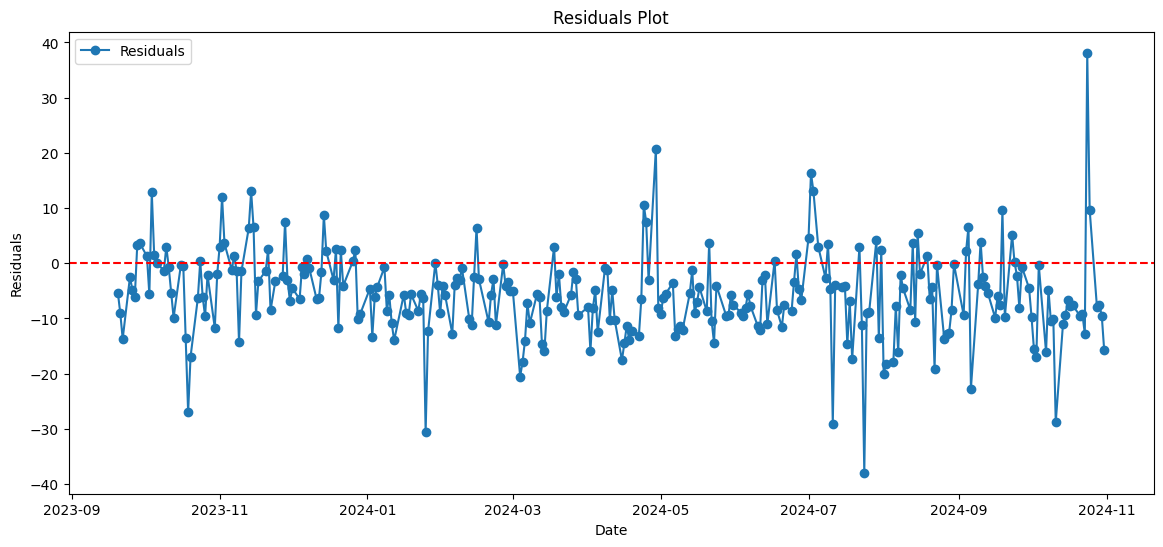

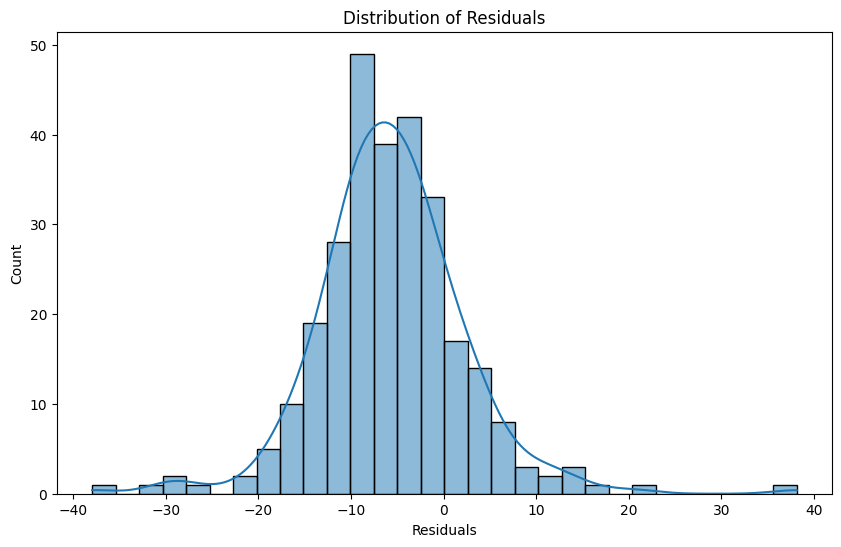

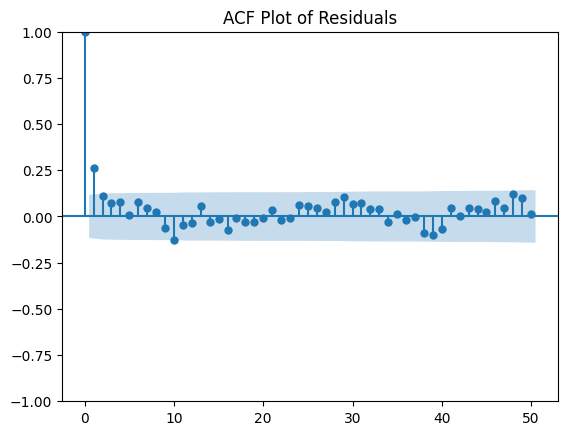

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Tính dư thừa trên tập kiểm tra
residuals = y_test_rescaled - test_predictions_rescaled

# Biểu đồ dư thừa
plt.figure(figsize=(14, 6))
plt.plot(merged_data.index[train_size + time_step:], residuals, marker='o', linestyle='-', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Histogram của dư thừa
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()

# Biểu đồ ACF cho dư thừa
plot_acf(residuals, lags=50)
plt.title('ACF Plot of Residuals')
plt.show()


Dickey-Fuller Test:
Statistic: -12.732031516180484
p-value: 9.330683458052036e-24

Jarque-Bera Test:
Statistic: 224.26148650616253
p-value: 2.005565976818929e-49


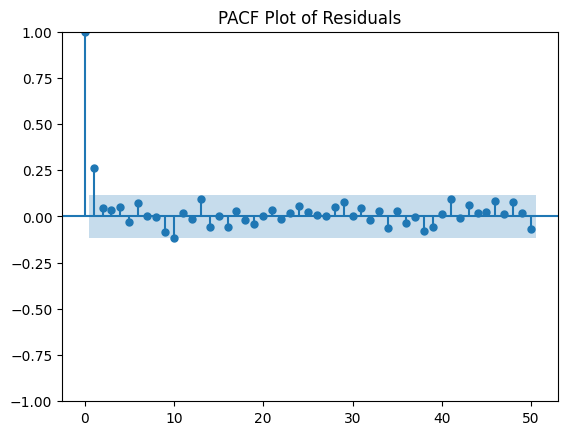

In [23]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Kiểm tra tính dừng với Dickey-Fuller test
adf_test = adfuller(residuals)
print('Dickey-Fuller Test:')
print(f'Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# Kiểm tra phân phối chuẩn với Jarque-Bera test
jb_test = jarque_bera(residuals)
print('\nJarque-Bera Test:')
print(f'Statistic: {jb_test[0]}')
print(f'p-value: {jb_test[1]}')

# Biểu đồ PACF
plot_pacf(residuals, lags=50)
plt.title('PACF Plot of Residuals')
plt.show()
